In [65]:
import requests
import json
import pandas as pd
import numpy as np
import re


from google.cloud import bigquery
import pyarrow
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [53]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/yolanda.ibanez/Documents/MoonPay/totemic-alchemy-433321-r4-a09286e03623.json"

In [76]:
# Define the API endpoint URL
url = "https://on-ramp.api.cx.metamask.io/providers/all/quote"

# Define the lists to iterate over
crypto_currency_ids = ["1/0x0000000000000000000000000000000000000000", "56/0x55d398326f99059ff775485246999027b3197955", "1/0xdac17f958d2ee523a2206206994597c13d831ec7"]

## us_states = ["us-al", "us-ak", "us-az", "us-ar", "us-ca", "us-co", "us-ct", "us-de", "us-fl", "us-ga", "us-hi", "us-id", "us-il", "us-in", "us-ia", "us-ks", "us-ky", "us-la", "us-me", "us-md", "us-ma", "us-mi", "us-mn", "us-ms", "us-mo", "us-mt", "us-ne", "us-nv", "us-nh", "us-nj", "us-nm", "us-ny", "us-nc", "us-nd", "us-oh", "us-ok", "us-or", "us-pa", "us-ri", "us-sc", "us-sd", "us-tn", "us-tx", "us-ut", "us-vt", "us-va", "us-wa", "us-wv", "us-wi", "us-wy"]
reduced_us_states =["us-al", "us-ak", "us-fl", "us-ga", "us-hi", "us-id"]
region_ids = ["de", "gb",] + reduced_us_states

payment_method_ids = ["debit-credit-card", "sepa-bank-transfer", "paypal"]

# Define the mapping of regionId to fiatCurrencyId
region_to_currency = {
    "de": "eur",  # Germany - Euro
    "gb": "gbp",  # United Kingdom - British Pound
    "us": "usd",  # United States - US Dollar
}

# Define the amountIn range and bins
min_amount = 30
max_amount = 30000
num_bins = 15  

# Calculate midpoints of the bins
amount_in_values = np.linspace(min_amount, max_amount, num_bins + 1)
midpoints = (amount_in_values[:-1] + amount_in_values[1:]) / 2

# Set up the headers
headers = {
    "accept": "application/json, text/plain, */*",
    "accept-encoding": "gzip, deflate, br, zstd",
    "accept-language": "en-GB,en-US;q=0.9,en;q=0.8",
    "origin": "https://portfolio.metamask.io",
    "referer": "https://portfolio.metamask.io/",
    "sec-ch-ua": '"Not)A;Brand";v="99", "Google Chrome";v="127", "Chromium";v="127"',
    "sec-ch-ua-mobile": "?0",
    "sec-ch-ua-platform": '"macOS"',
    "sec-fetch-dest": "empty",
    "sec-fetch-mode": "cors",
    "sec-fetch-site": "same-site",
    "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.0 Safari/537.36"
}

# Prepare a list to store the results
results = []

# Iterate over each combination of regionId, paymentMethodId, and cryptoCurrencyId
for region_id in region_ids:
    for payment_method_id in payment_method_ids:
        for crypto_currency_id in crypto_currency_ids:
            for amount_in in midpoints:
                #Determine the local currency based on the region
                base_region = region_id.split('-')[0]  # Extract base region like "us" from "us-ca"
                fiat_currency_id = region_to_currency.get(base_region, "/currencies/fiat/usd")  # Default to USD

                params = {
                    "regionId": f"/regions/{region_id}",
                    "paymentMethodId": f"/payments/{payment_method_id}",
                    "cryptoCurrencyId": f"/currencies/crypto/{crypto_currency_id}",
                    "fiatCurrencyId": f"/currencies/fiat/{fiat_currency_id}",
                    "amount": amount_in,
                    "frequency": "undefined",
                    "sdk": "1.28.3",
                    "context": "browser",
                    "keys": ""}


            
                # Send the GET request to the API
                response = requests.get(url, headers=headers, params=params)
            
                # Check if the request was successful (status code 200)
                if response.status_code == 200:
                    # Parse the JSON response
                    data = response.json()
                
                    # Extract relevant information and add to results
                    for item in data.get("success", []):
                        provider_name = item.get("provider", "").split("/providers/")[-1]
                        chain_id = item.get("quote", {}).get("crypto", {}).get("network", {}).get("chainId")
                        chain_name = item.get("quote", {}).get("crypto", {}).get("network", {}).get("chainName")
                        cryptoCurrencyId = crypto_currency_id.split("/")[-1]
                        results.append({
                            "regionId": region_id,
                            "cryptoCurrencyId": cryptoCurrencyId,
                            "providerName": provider_name,
                            "fiatCurrencyId": fiat_currency_id,
                            "amountIn": item.get("quote", {}).get("amountIn"),
                            "amountOut": item.get("quote", {}).get("amountOut"),
                            "exchangeRate": item.get("quote", {}).get("exchangeRate"),
                            "networkFee": item.get("quote", {}).get("networkFee"),
                            "providerFee": item.get("quote", {}).get("providerFee"),
                            "extraFee": item.get("quote", {}).get("extraFee"),
                            "chainId": chain_id,
                            "chainName": chain_name,
                            "paymentMethod": item.get("quote", {}).get("paymentMethod"),
                            "bestRate": item.get("quote", {}).get("bestRate", False)
                        })
                else:
                    # If the request failed, add an error message to the results list
                    results.append({
                        "regionId": region_id,
                        "cryptoCurrencyId": crypto_currency_id,
                        "providerName": None,
                        "amountIn": None,
                        "amountOut": None,
                        "exchangeRate": None,
                        "networkFee": None,
                        "providerFee": None,
                        "extraFee": None,
                        "chainId": None,
                        "chainName": None,
                        "paymentMethod": None,
                        "bestRate": None,
                        "error": f"Request failed with status code {response.status_code}. Response Text: {response.text}"
                    })

# Convert the results to a pandas DataFrame
df = pd.DataFrame(results)

In [77]:
# Calculate the spread and add it as a new column
df['spread'] =df['amountIn'] - (df['amountOut'] * df['exchangeRate']) - (df['networkFee'] + df['providerFee'] + df['extraFee'])

In [78]:

# Function to clean the provider names
def clean_provider_name(provider_name):
    # Use a regex to remove any trailing "-b", "-p", "-m", etc.
    clean_name = re.sub(r'-[a-zA-Z]$', '', provider_name)
    return clean_name

# Apply the function to the providerName column
df['providerName'] = df['providerName'].apply(clean_provider_name)

# Define the columns to group by (all except 'bestRate')
group_columns = [col for col in df.columns if col != 'bestRate']

# Group by these columns and select the first value of 'bestRate' within each group
df_final = df.groupby(group_columns, as_index=False).agg({
    'bestRate': 'first'
})



In [79]:
df_final.to_csv("result.csv")


In [61]:
# Initialize a BigQuery client
client = bigquery.Client()

# Define the dataset and table name
dataset_id = 'MoonPay_CaseStudy'
table_id = 'partial_scraping'

# Define the full table ID
table_ref = f"{client.project}.{dataset_id}.{table_id}"

# Optionally, delete the existing table (and schema) if you want a fresh start
try:
    client.delete_table(table_ref)  # Delete table if it exists
    print(f"Table {table_ref} deleted.")
except Exception as e:
    print(f"Error deleting table: {e}")

# Define schema if creating a new table
schema = [
    # Define schema as list of bigquery.SchemaField objects
    bigquery.SchemaField("regionId", "STRING"),
    bigquery.SchemaField("cryptoCurrencyId", "STRING"),
    bigquery.SchemaField("providerName", "STRING"),
    bigquery.SchemaField("fiatCurrencyId", "STRING"),
    bigquery.SchemaField("amountIn", "FLOAT"),
    bigquery.SchemaField("amountOut", "FLOAT"),
    bigquery.SchemaField("exchangeRate", "FLOAT"),
    bigquery.SchemaField("networkFee", "FLOAT"),
    bigquery.SchemaField("providerFee", "FLOAT"),
    bigquery.SchemaField("extraFee", "FLOAT"),
    bigquery.SchemaField("chainId", "INTEGER"),
    bigquery.SchemaField("chainName", "STRING"),
    bigquery.SchemaField("paymentMethod", "STRING"),
    bigquery.SchemaField("spread", "FLOAT"),
    bigquery.SchemaField("bestRate", "BOOLEAN")

]

# Load the DataFrame to BigQuery
job = client.load_table_from_dataframe(df_final, table_ref)

# Wait for the job to complete
job.result()
print(f"Loaded {job.output_rows} rows into {table_ref}.")

Table totemic-alchemy-433321-r4.MoonPay_CaseStudy.partial_scraping deleted.
Loaded 713 rows into totemic-alchemy-433321-r4.MoonPay_CaseStudy.partial_scraping.


In [63]:
df_final

Index(['regionId', 'cryptoCurrencyId', 'providerName', 'fiatCurrencyId',
       'amountIn', 'amountOut', 'exchangeRate', 'networkFee', 'providerFee',
       'extraFee', 'chainId', 'chainName', 'paymentMethod', 'spread',
       'bestRate'],
      dtype='object')

In [73]:
# Example filters - replace with your specific values
region_filter = 'gb'       # Replace with your regionId value
chain_filter = 'Ethereum Mainnet'       # Replace with your chainName value
payment_method_filter = 'debit-credit-card'  # Replace with your paymentMethod value

# Filter the DataFrame
filtered_df = df[
    (df['regionId'] == region_filter) & 
    (df['chainName'] == chain_filter) & 
    (df['paymentMethod'] == payment_method_filter)
]

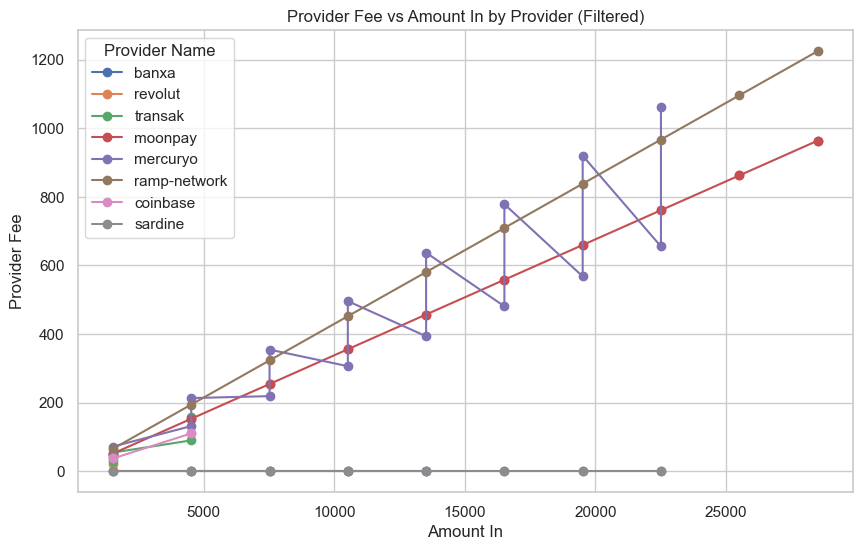

In [75]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Initialize the plot
plt.figure(figsize=(10, 6))

# Check if the filtered DataFrame is not empty
if not filtered_df.empty:
    # Loop through each provider and plot their line
    for provider in filtered_df['providerName'].unique():
        provider_data = filtered_df[filtered_df['providerName'] == provider]
        plt.plot(provider_data['amountIn'], provider_data['providerFee'], marker='o', label=provider)

    # Add titles and labels
    plt.title('Provider Fee vs Amount In by Provider (Filtered)')
    plt.xlabel('Amount In')
    plt.ylabel('Provider Fee')

    # Show legend only if there are providers to display
    if filtered_df['providerName'].nunique() > 0:
        plt.legend(title='Provider Name')

    # Display the plot
    plt.show()
else:
    print("No data available after filtering. Please check your filter criteria.")